In [2]:
# coding: utf-8
import numpy as np
from matplotlib import pyplot as plt
def orto(x):
    if np.dot(x,x) == 0:
        return 'No se puede: ese es el vector cero!'
    else:
        if 0 not in x:
            v1 = 1
            v2 = -(x[0]/x[1])
            v3 = 0
            #return np.array([v1,v2,v3])
        else:
            if x[0] == 0:
                if x[1] == 0:
                    v1 = 1
                    v2 = 0
                    v3 = 0
                else:
                    v1 = 0
                    v2 = 0
                    v3 = 1
            elif x[1] == 0:
                v1 = 0
                v2 = 1
                v3 = 0
            else:
                v1 = 0
                v2 = 0
                v3 = 1
        return np.array([v1,v2,v3])
    
#Funcion que regresa dos vectores; numpy arrays de 3D, ortogonales al vector de input x.
#Esto es, devuelven la base al espacio ortogonal definido por el vector x de entrada.
#@jit
def base_ort_nor(x):
    y = orto(x)
    v1 = y/np.linalg.norm(y)
    z = np.cross(x,v1)
    v2 = z/np.linalg.norm(z)
    return v1, v2


#Esta funcion genera un vector con distrubucion uniforme en las direcciones sobre un plano tangente a la esfera de radio R.
#@jit
def vector_des(v1,v2):
    na = 2*np.pi*np.random.rand()
    vn = v1*np.cos(na) + v2*np.sin(na)
    return vn/np.linalg.norm(vn)

R = 1.

#Normalizamos al vector de desplazamiento para que intersecte al vector de la nueva posicion de acuerdo con que el
#desplazamiento (s) sobre la esfera, sobre este arco de circulo maximo, sea el determinado por el movimiento browniano particular.
#@jit

######################################## VECTOR_Q NORMALIZADO FUERA DE TIEMPO##############################
######################################## VECTOR_Q SOBRE ESCRITO ABAJO, AL FINAL DEL CODIGO ################

def vector_q(x,s):
    q = (R)*np.tan(s/(R))
    return q*x

#Dados todos los datos anteriores, esta funcion actualiza la posicion de la particula.
#Lo que hace es que la mueve sobre el plano tangente a la esfera en la direccion predeterminada de tal suerte que el desplazamiento efectivo
#s sobre una geodesica de la esfera, se el deseado, y posteriormente la proyecta sobre la superficie de la esfera.
#@jit
def nuevo_r(r, vector_q):
    y = r + vector_q
    y = y/np.linalg.norm(y)
    return (R)*y

#funcion que incorpora el efecto de un campo externo



#Esta funcion ensambla todo lo anterior: como imput necesita una posicion inicial y un arco de desplazamiento
#Como output da un vector de posicion nuevo dada un tipo de desplazamiento.
#@jit
def actualiza(r,s):
    v1, v2 = base_ort_nor(r)
    pre_q = vector_des(v1,v2)
    q = vector_q(pre_q, s)
    return nuevo_r(r, q)




#Esta funcion actualiza la posicion de todos los elementos de una lista; particula brownianas.
#@jit


def act_n(lista, D, delta_t):
    l = []
    for v in lista:
        s = ese(D,delta_t)
        l.append(actualiza(v,s))
    return l



#Huella de la trayectoria
#La siguiente funcion hace una particion de la trayectoria sobre s en n pedazos y regresa
#una lista de los vectores de esas posiciones sobre la esfera.
#Usa al operador de rotacion.

#@jit
def b_steps_(ri,rf,n):
    l = [ri]
    r0 = ri
    lamb = (np.dot(ri,rf))/((np.linalg.norm(ri))*(np.linalg.norm(rf)))
    
    if abs(lamb) > 1:
        #print 'Is fucked up: there was a rounding '
        if lamb < 0:
            lamb = -1
        else:
            lamb = 1
    
    
    
    theta = np.arccos(lamb)
    #if theta < 1e17:
        #return l
    if theta == 0:
        return [ri,rf]
    
    else:

        normal = np.cross(ri, rf)/ np.linalg.norm(np.cross(ri,rf))
        for i in range(1,n + 1):
            #vi = rot_theta(r0, theta/n, normal)
            vi = rot_finita(r0, -normal, theta/n)
            l.append(vi)
            r0 = vi
        return l


#Operador de Rotacion
#Depende de los parametros r, el vector o punto que queremos rotar; theta el angulo de rotacion; n el vector que define el eje de rotacion y el signo de rotacion.


#@jit
def rot_theta(r, theta, u):
    x = np.array([np.cos(theta) + (u[0]*u[0])*(1 - np.cos(theta)), u[0]*u[1]*(1 - np.cos(theta)) - u[2]*np.sin(theta), u[0]*u[2]*(1 - np.cos(theta)) + u[1]*np.sin(theta)])
    y = np.array([u[1]*u[0]*(1 - np.cos(theta)) + u[2]*np.sin(theta), np.cos(theta) + u[1]*u[1]*(1 - np.cos(theta)), u[1]*u[2]*(1 - np.cos(theta)) - u[0]*np.sin(theta)])
    z = np.array([u[2]*u[0]*(1 - np.cos(theta)) - u[1]*np.sin(theta), u[2]*u[1]*(1 - np.cos(theta)) + u[0]*np.sin(theta), np.cos(theta) + u[2]*u[2]*(1 - np.cos(theta))])
    R = np.array([x,y,z])
    return np.dot(R, r)



#Transformacion de coordenada de esfericas a cartesianas.

#@jit
def trans_s_c(r,theta, phi):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)* np.sin(phi)
    z = r*np.cos(theta)
    return x, y, z



def trans_c_s(x,y,z):
    r = np.sqrt(x**2 + y**2 + z**2)
    #print r
    cociente = z/r
    if abs(cociente) > 1:
        if cociente < 0:
            theta = np.arccos(-1)
        else:
            theta = np.arccos(1)
    else:
        
        theta = np.arccos(z/r)
    #Aqui hay un problema relevante: cada vez que y o x sean nulos, habra un problema
    #de indefinicion de operacion
    if x == 0.:
        if y == 0.:
            phi = 2*np.pi*np.random.rand()
    else:
        if x < 0:
            phi = np.arctan(y/x) + np.pi
        else:
            if y < 0:
                phi = np.arctan(y/x) + 2*np.pi
            else:
                
                phi = np.arctan(y/x)
    return r, theta, phi




#Base unitaria para las coordenadas esféricas
#@jit
def r_uni(theta, phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.cos(theta)*np.cos(phi)
    z = np.cos(theta)
    return np.array([x,y,z])
#@jit
def theta_uni(theta, phi):
    x = np.cos(theta)*np.cos(phi)
    y = np.cos(theta)*np.sin(phi)
    z = -np.sin(theta)
    return np.array([x,y,z])
#@jit
def phi_uni(theta, phi):
    x = -np.sin(phi)
    y = np.cos(phi)
    z = 0
    return np.array([x,y,z])

#Función que normaliza los nombres para las animaciones de tal suerte que tenga el mismo número de
#digitos y se iteren en orden
#@jit
def nombre(s):
    diferencia = 4 - len(str(s))
    ceros = '' 
    for i in range(diferencia):
        ceros = ceros + '0'
    variable = ceros + str(s)
    return variable

#Varianza para una distribucion bigaussiana; difusion en 2D
#@jit
def var(D, delta_t):
    return 4*D*delta_t


#Arco de circulo maximo con distribucion normal alrededor de cero y una varianza dada por
#@jit
def ese(D,delta_t):
    return abs(np.random.normal(loc = 0., scale = np.sqrt(var(D,delta_t)),size = None))

#Funcion de rotacion finita
#@jit
def rot_finita(r_ini, N, Phi):
    n = N/np.linalg.norm(N)
    r_fin = np.cos(Phi)*r_ini + (np.dot(n,r_ini))*(1 - np.cos(Phi))*n + (np.sin(Phi))*(np.cross(r_ini,n))
    return r_fin


#Funcion que regresa una lista de n numpy arrays que son l
def Trayectoria(ri,rf,n):
    l = [ri]
    r0 = ri
    theta = np.arccos((np.dot(ri,rf))/((np.linalg.norm(ri))*(np.linalg.norm(rf))))
    N = np.cross(ri, rf)
    
    for i in range(1,n + 1):
        vi = rot_finita(r0, N, theta/n)
        l.append(vi)
        r0 = vi
    return l

#Collision_check es una función que, dada una trayectoria: una lista de vectores que
#pasan por puntos sucesivos de la trayectoria, verifica si alguna de estas posiciones
#interesecto a alguno de los obstáculos. En caso de que así sea, actualiza conforme una
#colision elastica. En caso de no intersectar a ningun obstaculo regresa una lista
#con dos vectores: posicion inicial y posicion final en ese orden.
#@jit
def penetrate_obs(lista_vect, lista_obs, size):
    metiches = []
    for obs in lista_obs:
        theta_omega = size
        r_omega = obs
        frontera = .2
        #metiches = []
        for v in lista_vect:
            tamanho = np.cos(theta_omega - frontera)
            if np.dot(v,r_omega) > tamanho:
                print('Penetro el mother fucker obstacle')
                metiches.append(v)
                
            else:
                continue
    #print 'no choco el mother fucker'
    #valor = False
    return metiches


#Esta funcion cuando es llamada grafia la posicion de las partoculas brownianas.
#sobre la superficie de una esfera sobre la que se esta difundiendo.
#@jit
def plot_particles(lista, vpolar, vazim, numero):
    from mpl_toolkits.mplot3d import axes3d
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    #import matplotlib.pyplot as plt
    #import numpy as np
    from itertools import product, combinations
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")
    ax._axis3don = False

    



    #draw sphere
    R = 1
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x=R*np.cos(u)*np.sin(v)
    y=R*np.sin(u)*np.sin(v)
    z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.15)

    ax.plot_surface(x, y, z, cmap=cm.YlGnBu_r,rstride=1, cstride=1, alpha = 0.10, linewidth = 0.10)
    ax.view_init(vpolar, vazim)
    
    
    #draw an arrow or a set of arrow
    #ax.quiver(0,0,1.5,0,0,1, length=0.5, arrow_length_ratio = .5, color = "b")
    #ax.quiver(1.5,0,0,1,0,0, length=0.5, arrow_length_ratio = .5, color ="g")
    #ax.quiver(0,1.5,0,0,1,0, length=0.5, arrow_length_ratio = .5, color ="r")
    #draw patch
    #u, v = np.mgrid[0:2*np.pi:50j, 0:(np.pi/7):50j]
    #x=R*np.cos(u)*np.sin(v)
    #y=R*np.sin(u)*np.sin(v)
    #z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.25)    
    
    #draw points
    for p in lista:
        ax.scatter([p[0]],[p[1]],[p[2]],color="b",s=15, alpha = 0.25)
    
    fig.savefig('SHY10_Field_X01_Img{}.png'.format(nombre(numero)))
    #ax.view_init(80, 30)
    #plt.show()
    plt.close()

    
    
#@jit
def polo_n(n, R):
    l = []
    for i in range(n):
        l.append(np.array([0,0,R]))
    return l

#@jit
def particion_esfera(ccero, Nphi):
    Ntheta = int(4*np.pi/(ccero*Nphi))
    print('Ntheta', Ntheta, 'Nphi', Nphi, 'Ntheta*Nphi', Ntheta*Nphi)
    sigmaPhi = 2*np.pi/Nphi
    deltaphi = 2*np.pi/Nphi
    thetas = []
    phis = [0]
    cociente = ccero/sigmaPhi
    for i in range(Ntheta + 1):
        theta = np.arccos(1 - (i)*cociente)
        thetas.append(theta)
    for j in range(Nphi):
        phis.append(phis[j] + deltaphi)
    return thetas, phis

#@jit
def secuencia_part(tamini, Nfi, numero):
    l1, l2 = particion_esfera(4*np.pi/tamini, Nfi)
    particion = []
    for i in range(len(l2)):
        for j in range(len(l1)):
            x, y, z = trans_s_c(1, l1[j], l2[i])
            particion.append(np.array([x, y, z]))
            
    return plot_particles(particion, 45, 45, numero)

#Funcion que regresa las coordenadas del centro de dos arreglos para 
#las coordenadas theta y phi
#@jit
def coordenadas_centro(l1,l2):
    thetas_centro = []
    phis_centro = []
    for i in range(len(l1) - 1):
        theta_media = l1[i] + (l1[i + 1] - l1[i])/2.
        thetas_centro.append(theta_media)
    for j in range(len(l2) - 1):
        phi_media = l2[j] + (l2[j + 1] - l2[j])/2.
        phis_centro.append(phi_media)
    return thetas_centro, phis_centro

#@jit(nopython=True)
def secuencia_obs(N, Nfi, numero):
    l1_prima, l2_prima = particion_esfera(4*np.pi/N, Nfi)
    l1, l2 = coordenadas_centro(l1_prima, l2_prima)
    particion = []
    for i in range(len(l2)):
        for j in range(len(l1)):
            x, y, z = trans_s_c(1, l1[j], l2[i])
            particion.append(np.array([x, y, z]))
            
    print(len(particion))
    
    #return plot_particles(particion, 0, 0, numero)
    return particion


def plot_particle_traj_obs(lista_obstaculos, trayectoria,  vpolar, vazim, numero):
    from mpl_toolkits.mplot3d import axes3d
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    #import matplotlib.pyplot as plt
    #import numpy as np
    from itertools import product, combinations
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")
    ax._axis3don = False
    

    



    #draw sphere
    R = 1
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x=R*np.cos(u)*np.sin(v)
    y=R*np.sin(u)*np.sin(v)
    z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.15)

    ax.plot_surface(x, y, z, cmap=cm.YlGnBu_r,rstride=1, cstride=1, alpha = 0.10, linewidth = 0.15)
    ax.view_init(vpolar, vazim)
    #draw patch
    #u, v = np.mgrid[0:2*np.pi:50j, 0:(np.pi/7):50j]
    #x=R*np.cos(u)*np.sin(v)
    #y=R*np.sin(u)*np.sin(v)
    #z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.25)
    
    
    
    #draw obstacles
    
    for p in lista_obstaculos:
        ax.scatter([p[0]],[p[1]],[p[2]], color="b", s=10, alpha = 0.2)
    
    #draw trajectory
    for p in trayectoria:
        ax.scatter([p[0]],[p[1]],[p[2]], color="k",s=20, alpha = 0.7)
    
    #Plot the x positive direction
    
    ax.quiver(1.5,0,0,1,0,0, length=0.5, arrow_length_ratio = .5)
    ax.quiver(0,1.5,0,0,1,0, length=0.5, arrow_length_ratio = .5)
    ax.quiver(0,0,1.5,0,0,1, length=0.5, arrow_length_ratio = .5)
    
    #fig.savefig('BS_24_Obs_test_01{}.png'.format(nombre(numero + 1)))
    #ax.view_init(80, 30)
    #plt.close()
    plt.show()

def obs_uniforme(N, R, size):
    
    list_obs = []
    omega = np.cos(size)
    while len(list_obs) < N:
        x, y, z = np.random.uniform(-1,1), np.random.uniform(-1,1), np.random.uniform(-1,1)
        v = np.array([x, y, z])
        norma = np.linalg.norm(v)
        if norma <= R:
            n = v/norma
            if not np.dot(n, np.array([0.,0.,1.]))/R > omega:
                list_obs.append(R*n)
    
    return list_obs    


def puntos_obs_j(r_omega, theta_omega, n):
    r , theta, phi = trans_c_s(r_omega[0],r_omega[1],r_omega[2])
    rp = rot_finita(r_omega, phi_uni(theta, phi), theta_omega)
    puntos_obs_j = [rp]
    for i in range(1,n):
        x = rot_finita(rp, r_omega, 2*np.pi/n)
        puntos_obs_j.append(x)
        rp = x
    return puntos_obs_j



def puntos_obs(lista_obstaculos, size):
    mis_obs = []
    for i in range(len(lista_obstaculos)):
        a = lista_obstaculos[i]
        b = size
        mis_obs = mis_obs + puntos_obs_j(a,b,100)
    return mis_obs
#Collision_check es una función que, dada una trayectoria: una lista de vectores que
#pasan por puntos sucesivos de la trayectoria, verifica si alguna de estas posiciones
#interesecto a alguno de los obstáculos. En caso de que así sea, actualiza conforme una
#colision elastica. En caso de no intersectar a ningun obstaculo regresa una lista
#con dos vectores: posicion inicial y posicion final en ese orden.

def penetrate_obs(lista_vect, lista_obs, size):
    metiches = []
    for obs in lista_obs:
        r_omega, theta_omega = obs, size
        #frontera = .2
        #metiches = []
        for v in lista_vect:
            tamanho = np.cos(theta_omega)
            if np.dot(v,r_omega) >= tamanho:
                #print 'Penetro el mother fucker obstacle'
                metiches.append(v)
                
            else:
                continue
    #print 'no choco el mother fucker'
    #valor = False
    return metiches
    

def check_collision(lista_vect, lista_obs, size):
    for obs in lista_obs:
        r_omega, theta_omega = obs, size 
        for v in lista_vect:
            tamanho = np.cos(theta_omega)
            if np.dot(v,r_omega) > tamanho:
                return  True
            else:
                continue
    return False
 

    
#############################################################################################################
#############################################################################################################
#############################################################################################################


#Hay que modificar esto cuando hay mas interacciones!!!! Al final va el rescalamiento con la tangente; no con
#cada termino individual sino con la suma en el espacio tangente.


def vector_q(x,s):
    #q = np.tan(s)
    q = s
    return q*x

#Distribución en el polo sur

def polo_s(n, R):
    l = []
    for i in range(n):
        l.append(np.array([0,0,-R]))
    return l

#Dsitribución en el ecuador

def dist_ecuador(n):
    l = []
    for i in range(n):
        x, y, z = trans_s_c(1.,np.pi/2, np.random.uniform(0,2*np.pi))
        l.append(np.array([x,y,z]))
    return l



In [3]:
def nuevo_r_field(r, vector_q, field):
    #nfield = np.tan(field)
    v_sum = field + vector_q
    xf = np.linalg.norm(v_sum)
    if xf == 0:
        nfield = 0
    else:
        fvecuni = (v_sum)/xf
        nfield = np.tan(xf)*fvecuni
    #y = r + vector_q + nfield
    y = r + nfield
    y = y/np.linalg.norm(y)
    return y



coff = np.sqrt((3./(4*np.pi)))

def field_theta(ri, v0):
    r, theta, phi = trans_c_s(ri[0],ri[1],ri[2])
    
    theta_field = coff*(np.sin(theta))
    
    phi_field = 0.
    
    field = v0*(theta_field)*theta_uni(theta, phi)
    
    return field

def actualiza_field_theta(r,s,v0):
    v1, v2 = base_ort_nor(r)
    pre_q = vector_des(v1,v2)
    q = vector_q(pre_q, s)
    return nuevo_r_field(r, q, field_theta(r,v0))
    #return nuevo_r_field(r, pre_q, field_theta(r,v0))


def act_n_field(lista, v0):
    l = []
    for v in lista:
        s = ese(D,dt)
        l.append(actualiza_field_theta(v, s, v0))
    return l


In [4]:
def mean_var_hist_theta(lista):
    thetas = []
    for r in lista:
        cociente = r[2]
        if abs(cociente) > 1.:
            if cociente < 0:
                theta = np.arccos(-1)
            else:
                theta = np.arccos(1)
        else:

            theta = np.arccos(r[2])
            
        thetas.append(theta)
        
    return thetas, np.mean(thetas), np.var(thetas)

In [5]:
def mean_var_hist_phis(lista):
    phis = []
    for r in lista:
        
        if r[0] == 0:
            if r[1] == 0:
                phi = 2*np.pi*np.random.rand()
        else:
            if r[0] < 0:
                
                phi = np.arctan(r[1]/r[0]) + np.pi
                    
            else:
                if r[1] < 0:
                    phi = np.arctan(r[1]/r[0]) + 2*np.pi
                else:
                
                    phi = np.arctan(r[1]/r[0])
                
        phis.append(phi)
    return phis, np.mean(phis), np.var(phis)

In [6]:
%matplotlib inline

In [7]:
import scipy as sci
import scipy.special as sp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

In [138]:
from __future__ import division
def Plot_Spherical_lm(l,m, numero,t,vp,va):
    
    PHI, THETA = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
    #R = sp.sph_harm(m, l, PHI, THETA).real
    #R = abs(sp.sph_harm(m, l, PHI, THETA))
    
    
    #R = 1 - 2.5*np.sqrt(sp.sph_harm(m, l, PHI, THETA).real**2 + sp.sph_harm(m, l, PHI, THETA).imag**2)
    #R = 1.*np.cos(THETA)
    R = 1/4*(-5/2.*np.cos(THETA)**3 - 3/2.*np.cos(THETA))
    
    #R = np.abs(R*np.cos(2*t))
    #R = np.sin(THETA)
    #R = 2*np.sin(THETA)*np.cos(THETA)
    #R = 3*np.sin(THETA) - 15*np.cos(THETA)**2
    X = R * np.sin(THETA) * np.cos(PHI) + np.sin(THETA) * np.cos(PHI)
    Y = R * np.sin(THETA) * np.sin(PHI) + np.sin(THETA) * np.sin(PHI)
    Z = R * np.cos(THETA) + np.cos(THETA)
    
    
    X1 = np.sin(THETA) * np.cos(PHI)
    Y1 = np.sin(THETA) * np.sin(PHI)
    Z1 = np.cos(THETA)

    #As R has negative values, we'll use an instance of Normalize
    #see http://stackoverflow.com/questions/25023075/normalizing-colormap-used-by-facecolors-in-matplotlib
    norm = colors.Normalize()
    plt.rc("text", usetex = True)
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(14,10))
    m = cm.ScalarMappable(cmap=cm.jet)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=cm.jet(norm(R)), alpha = 0.5)
    ax.plot_surface(X1, Y1, Z1, rstride=1, cstride=1, facecolors=cm.jet(norm(R)), alpha = .15)
    ax.set_title(r'$ |Y_{{}}^{{}}(\theta, \phi)| $'.format(str(l),str(m)), fontsize=24)
    #ax.set_xlim(-0.5,0.5)
    #ax.set_ylim(-0.5,0.5)
    #ax.set_zlim(-0.5,0.5)
    m.set_array(R)
    ax.view_init(vp,va)
    fig.colorbar(m, shrink=0.8)
    ax.set_axis_off()
    #plt.savefig("SphericalHarmonicY22_{}".format(nombre(numero)))
    #plt.close();

In [143]:
PHI, THETA = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
sp.sph_harm(0, 3, PHI, THETA).imag

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

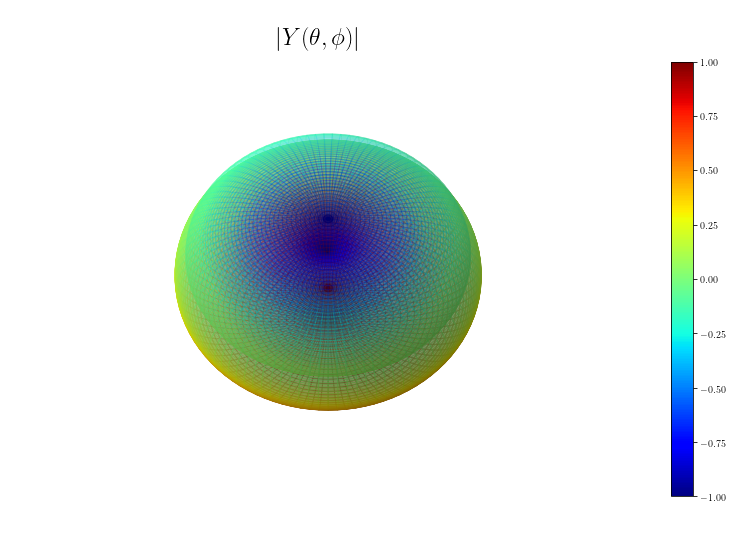

In [145]:
Plot_Spherical_lm(1,0, 0,0,70,0)

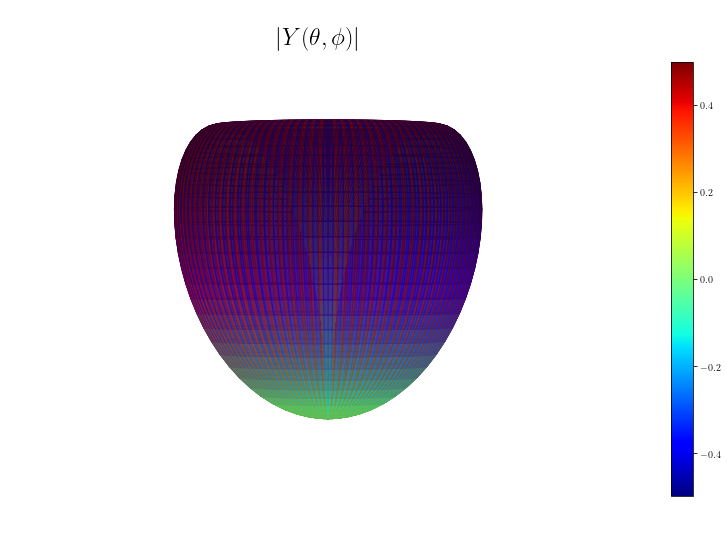

In [76]:
Plot_Spherical_lm(2,0, 0,0,0,0)

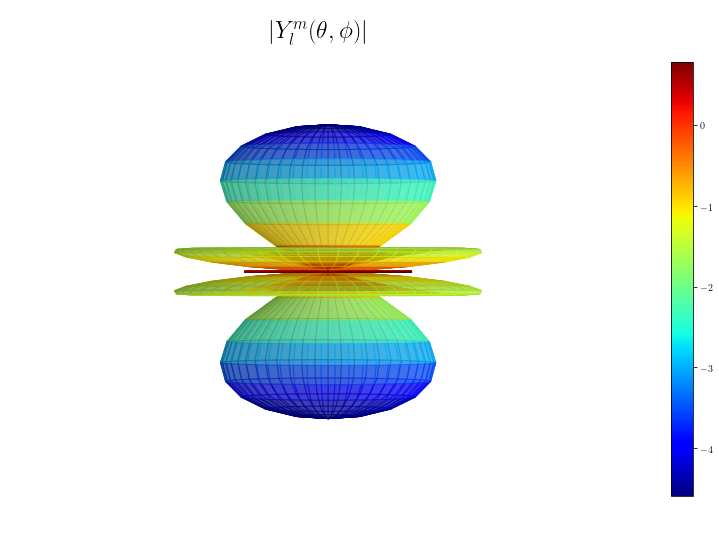

In [40]:
Plot_Spherical_lm(3,0, 0,0,0,0)

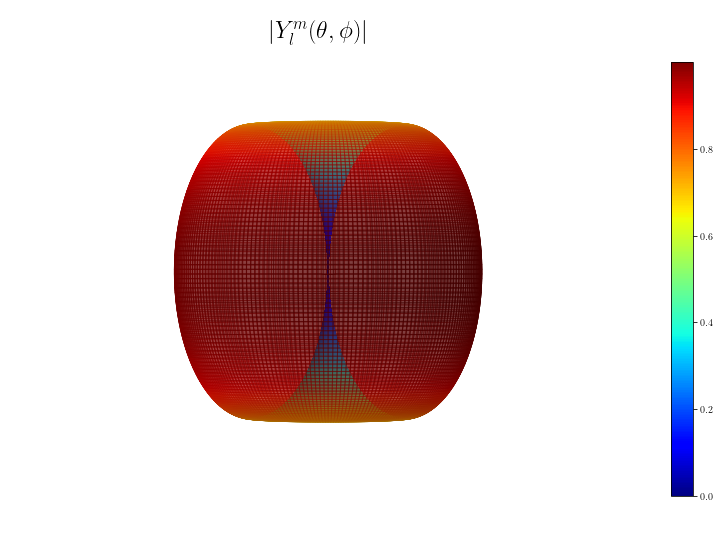

In [25]:
Plot_Spherical_lm(1,0, 0,0,0,0)

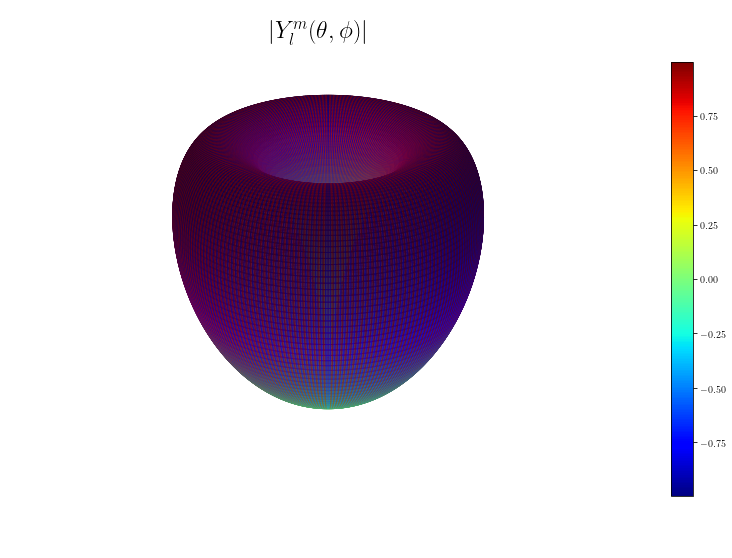

In [28]:
Plot_Spherical_lm(2,0, 0,0,30,0)

In [1]:
Plot_Spherical_lm(3,0, 0,0,40,0)

NameError: name 'Plot_Spherical_lm' is not defined

In [4]:
%matplotlib inline

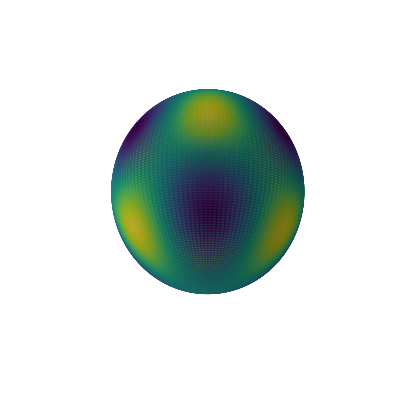

In [5]:
phi_sh = np.linspace(0, np.pi, 120)
theta_sh = np.linspace(0, 2*np.pi, 120)
phi_sh, theta_sh = np.meshgrid(phi_sh, theta_sh)

# The Cartesian coordinates of the unit sphere
x_sh = np.sin(phi_sh) * np.cos(theta_sh)
y_sh = np.sin(phi_sh) * np.sin(theta_sh)
z_sh = np.cos(phi_sh)

l, m = 4, 3

# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = -sp.sph_harm(m, l, theta_sh, phi_sh).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

# Set the aspect ratio to 1 so our sphere looks spherical
#fig = plt.figure(figsize=plt.figaspect(1.))
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_sh, y_sh, z_sh,  rstride=1, cstride=1, facecolors=cm.viridis(fcolors), alpha = 0.76)
# Turn off the axis planes
ax.set_axis_off()
ax.view_init(-20,0)
plt.show()

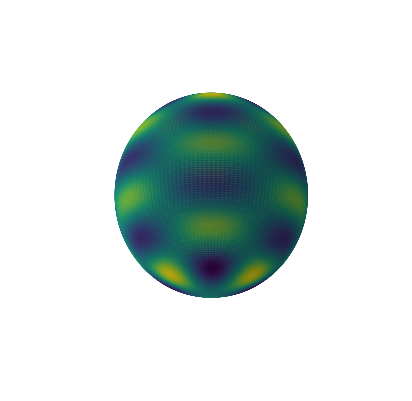

In [13]:
phi_sh = np.linspace(0, np.pi, 140)
theta_sh = np.linspace(0, 2*np.pi, 140)
phi_sh, theta_sh = np.meshgrid(phi_sh, theta_sh)

# The Cartesian coordinates of the unit sphere
x_sh = np.sin(phi_sh) * np.cos(theta_sh)
y_sh = np.sin(phi_sh) * np.sin(theta_sh)
z_sh = np.cos(phi_sh)

l, m = 8, 3

# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = -sp.sph_harm(m, l, theta_sh, phi_sh).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

# Set the aspect ratio to 1 so our sphere looks spherical
#fig = plt.figure(figsize=plt.figaspect(1.))
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_sh, y_sh, z_sh,  rstride=1, cstride=1, facecolors=cm.viridis(fcolors), alpha = 0.76)
# Turn off the axis planes
ax.set_axis_off()
ax.view_init(-20,0)
plt.show()

/Users/adrianovaldesgomez/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/adrianovaldesgomez/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/adrianovaldesgomez/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


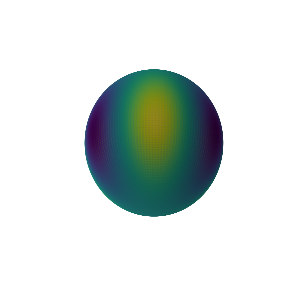

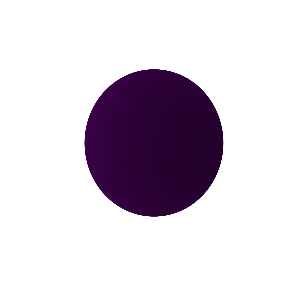

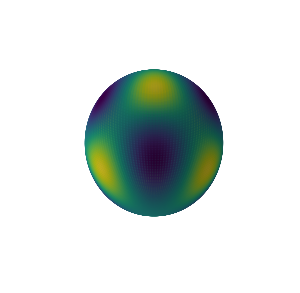

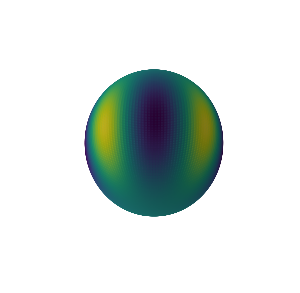

In [24]:
for i in range(0,2):
    for j in range(0,2):
        # The Cartesian coordinates of the unit sphere
        x_sh = np.sin(phi_sh) * np.cos(theta_sh)
        y_sh = np.sin(phi_sh) * np.sin(theta_sh)
        z_sh = np.cos(phi_sh)

        l, m = i+3, j+3

        # Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
        fcolors = -sp.sph_harm(m, l, theta_sh, phi_sh).real
        fmax, fmin = fcolors.max(), fcolors.min()
        fcolors = (fcolors - fmin)/(fmax - fmin)

        # Set the aspect ratio to 1 so our sphere looks spherical
        #fig = plt.figure(figsize=plt.figaspect(1.))
        fig = plt.figure(figsize = (5,5))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(x_sh, y_sh, z_sh,  rstride=1, cstride=1, facecolors=cm.viridis(fcolors), alpha = 0.76)
        # Turn off the axis planes
        ax.set_axis_off()
        ax.view_init(-20,0)
        
plt.show()

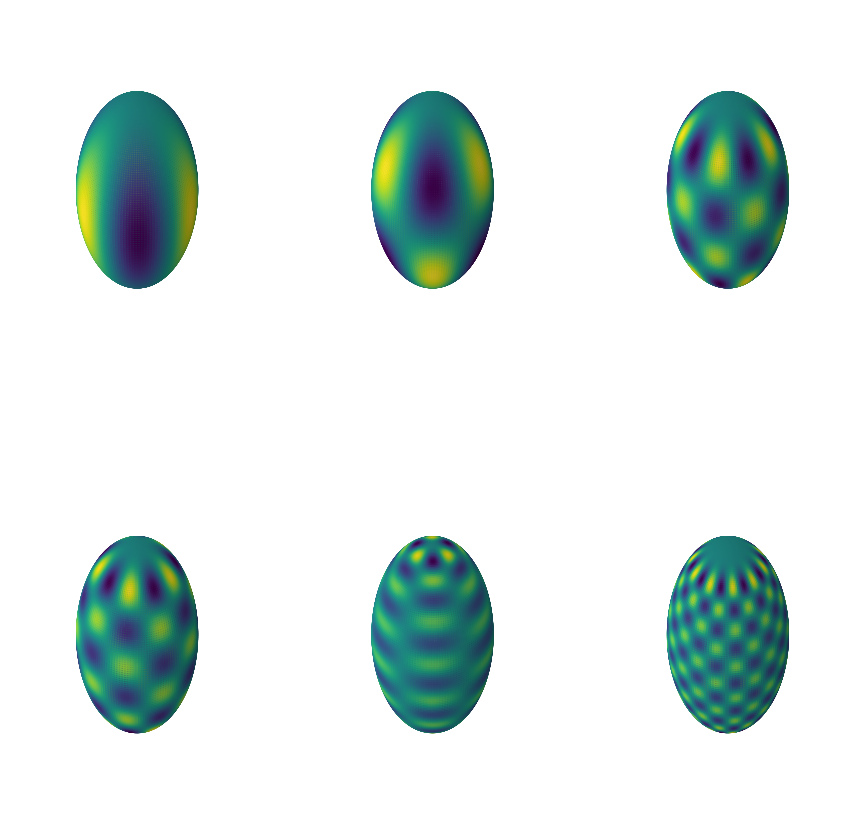

In [36]:
l, m = 3, 3
# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = -sp.sph_harm(m, l, theta_sh, phi_sh).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)


# Set the aspect ratio to 1 so our sphere looks spherical
#fig = plt.figure(figsize=plt.figaspect(1.))

fig = plt.figure(figsize = (15,15))



ax1 = fig.add_subplot(231, projection='3d')
ax1.plot_surface(x_sh, y_sh, z_sh,  rstride=1, cstride=1, facecolors=cm.viridis(fcolors), alpha = 0.76)
ax1.set_axis_off()

l, m = 4, 3
# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = -sp.sph_harm(m, l, theta_sh, phi_sh).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)
# Set the aspect ratio to 1 so our sphere looks spherical
#fig = plt.figure(figsize=plt.figaspect(1.))
#fig = plt.figure(figsize = (7,7))
ax2 = fig.add_subplot(232, projection='3d')
ax2.plot_surface(x_sh, y_sh, z_sh,  rstride=1, cstride=1, facecolors=cm.viridis(fcolors), alpha = 0.76)
ax2.set_axis_off()


l, m = 8, 5
# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = -sp.sph_harm(m, l, theta_sh, phi_sh).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)
# Set the aspect ratio to 1 so our sphere looks spherical
#fig = plt.figure(figsize=plt.figaspect(1.))
#fig = plt.figure(figsize = (7,7))
ax3 = fig.add_subplot(233, projection='3d')
ax3.plot_surface(x_sh, y_sh, z_sh,  rstride=1, cstride=1, facecolors=cm.viridis(fcolors), alpha = 0.76)
ax3.set_axis_off()




#########################################################################################################

l, m = 10, 5
# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = -sp.sph_harm(m, l, theta_sh, phi_sh).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)
# Set the aspect ratio to 1 so our sphere looks spherical
#fig = plt.figure(figsize=plt.figaspect(1.))
#fig = plt.figure(figsize = (7,7))
ax4 = fig.add_subplot(234, projection='3d')
ax4.plot_surface(x_sh, y_sh, z_sh,  rstride=1, cstride=1, facecolors=cm.viridis(fcolors), alpha = 0.76)
ax4.set_axis_off()

l, m = 15, 3
# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = -sp.sph_harm(m, l, theta_sh, phi_sh).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)
# Set the aspect ratio to 1 so our sphere looks spherical
#fig = plt.figure(figsize=plt.figaspect(1.))
#fig = plt.figure(figsize = (7,7))
ax5 = fig.add_subplot(235, projection='3d')
ax5.plot_surface(x_sh, y_sh, z_sh,  rstride=1, cstride=1, facecolors=cm.viridis(fcolors), alpha = 0.76)
ax5.set_axis_off()


l, m = 20, 10
# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = -sp.sph_harm(m, l, theta_sh, phi_sh).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)
# Set the aspect ratio to 1 so our sphere looks spherical
#fig = plt.figure(figsize=plt.figaspect(1.))
#fig = plt.figure(figsize = (7,7))
ax6 = fig.add_subplot(236, projection='3d')
ax6.plot_surface(x_sh, y_sh, z_sh,  rstride=1, cstride=1, facecolors=cm.viridis(fcolors), alpha = 0.76)
ax6.set_axis_off()


# Turn off the axis planes
#ax1.set_axis_off()
ax.view_init(90,0)
plt.show()

In [10]:
!pwd

/Users/adrianovaldesgomez/Documents/Adriano_Programming


In [11]:
%cd ..

/Users/adrianovaldesgomez/Documents


In [12]:
!mkdir Y10_28_10_2017

In [11]:
%cd Y10_28_10_2017/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Y10_28_10_2017


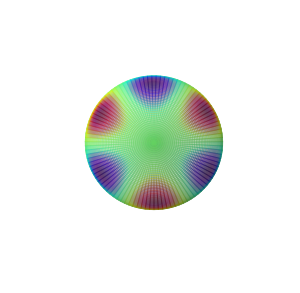

In [11]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_sh, y_sh, z_sh,  rstride=1, cstride=1, facecolors=cm.jet(fcolors), alpha = 0.2)
# Turn off the axis planes
ax.set_axis_off()
ax.view_init(90,0)
plt.savefig("TopCLSphericalHarmonicYl1m0", dpi = 150)
plt.show()

### Administración de carpetas

In [5]:
!pwd

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Foreign_Notebooks


In [16]:
%cd ..

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Foreign_Notebooks


In [7]:
!mkdir SH_Sim_Y10_01

In [8]:
%cd SH_Sim_Y10_01/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/SH_Sim_Y10_01


### Simulación

In [11]:
D = 1e-1
dt = np.log(2)*1e-3
v0 = 20*np.sqrt(2*D)*dt
dist_uni = obs_uniforme(700, 1., 0)
#dist_uni = polo_n(600,1.)
plot_particles(dist_uni, 0, 0, 0)
rs = dist_uni
for i in range(700):
         
        nuevas_pos = act_n_field(rs, v0)
        plot_particles(nuevas_pos, 0, 0, i + 1)
        rs = nuevas_pos

### Animación

In [18]:
!mencoder "mf://*.png" -o SHY10_Animation_01.mov -ovc lavc -lavcopts vcodec=msmpeg4v2:autoaspect:vbitrate=2160000:mbd=2:keyint=132:vqblur=1.0:cmp=2:subcmp=2:dia=2:o=mpv_flags=+mv0:last_pred=3 -fps 20;
                                        
                                        

MEncoder 1.3.0-4.2.1 (C) 2000-2016 MPlayer Team
224 audio & 451 video codecs

success: format: 16  data: 0x0 - 0x0
MF file format detected.
[mf] search expr: *.png
[mf] number of files: 701 (5608)
[demux_mf] file type was not set! trying 'type=png'...
VIDEO:  [MPNG]  0x0  24bpp  25.000 fps    0.0 kbps ( 0.0 kbyte/s)
[V] filefmt:16  fourcc:0x474E504D  size:0x0  fps:25.000  ftime:=0.0400
Input fps will be interpreted as 20.000 instead.
libavcodec version 57.24.102 (internal)
Opening video filter: [expand osd=1]
Expand: -1 x -1, -1 ; -1, osd: 1, aspect: 0.000000, round: 1
Opening video decoder: [ffmpeg] FFmpeg's libavcodec codec family
Selected video codec: [ffpng] vfm: ffmpeg (FFmpeg PNG)
Could not find matching colorspace - retrying with -vf scale...
Opening video filter: [scale]
Movie-Aspect is undefined - no prescaling applied.
[swscaler @ 0x101bce410]bicubic scaler, from rgba to yuv420p using MMXEXT
videocodec: libavcodec (576x576 fourcc=3234504d [MP42])
[VE_LAVC] High quality encodi

Pos:   1.9s     39f ( 5%) 32.47fps Trem:   0min  11mb  A-V:0.000 [2506:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   2.0s     40f ( 5%) 31.80fps Trem:   0min  12mb  A-V:0.000 [2499:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   2.0s     41f ( 5%) 31.27fps Trem:   0min  12mb  A-V:0.000 [2493:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   2.1s     42f ( 6%) 30.86fps Trem:   0min  10mb  A-V:0.000 [2487:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   2.1s     43f ( 6%) 30.85fps Trem:   0min  10mb  A-V:0.000 [2481:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   2.2s     44f ( 6%) 30.88fps Trem:   0min  10mb  A-V:0.000 [2475:0]
[

Pos:   4.2s     84f (12%) 33.91fps Trem:   0min   9mb  A-V:0.000 [2344:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   4.2s     85f (12%) 33.92fps Trem:   0min   9mb  A-V:0.000 [2342:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   4.3s     86f (12%) 33.90fps Trem:   0min  10mb  A-V:0.000 [2339:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   4.3s     87f (12%) 33.98fps Trem:   0min  10mb  A-V:0.000 [2336:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   4.4s     88f (12%) 34.08fps Trem:   0min  10mb  A-V:0.000 [2333:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   4.5s     89f (12%) 34.06fps Trem:   0min  10mb  A-V:0.000 [2331:0]
[

Pos:   6.5s    129f (18%) 36.34fps Trem:   0min   9mb  A-V:0.000 [2260:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   6.5s    130f (18%) 36.42fps Trem:   0min   9mb  A-V:0.000 [2258:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   6.5s    131f (18%) 36.53fps Trem:   0min   9mb  A-V:0.000 [2257:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   6.6s    132f (18%) 36.46fps Trem:   0min   9mb  A-V:0.000 [2254:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   6.7s    133f (19%) 36.62fps Trem:   0min   9mb  A-V:0.000 [2261:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   6.7s    134f (19%) 36.69fps Trem:   0min   9mb  A-V:0.000 [2259:0]
[

Pos:   8.8s    175f (25%) 36.73fps Trem:   0min   9mb  A-V:0.000 [2197:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   8.8s    176f (25%) 36.78fps Trem:   0min   9mb  A-V:0.000 [2196:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   8.8s    177f (25%) 36.85fps Trem:   0min   9mb  A-V:0.000 [2195:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   8.9s    178f (25%) 36.93fps Trem:   0min   9mb  A-V:0.000 [2193:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   8.9s    179f (25%) 36.98fps Trem:   0min   9mb  A-V:0.000 [2191:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:   9.0s    180f (25%) 37.05fps Trem:   0min   9mb  A-V:0.000 [2190:0]
[

Pos:  13.2s    264f (37%) 38.28fps Trem:   0min   8mb  A-V:0.000 [2061:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  13.2s    265f (37%) 38.33fps Trem:   0min   8mb  A-V:0.000 [2063:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  13.3s    266f (38%) 38.38fps Trem:   0min   8mb  A-V:0.000 [2061:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  13.3s    267f (38%) 38.43fps Trem:   0min   8mb  A-V:0.000 [2060:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  13.4s    268f (38%) 38.40fps Trem:   0min   8mb  A-V:0.000 [2058:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  13.4s    269f (38%) 38.42fps Trem:   0min   8mb  A-V:0.000 [2057:0]
[

Pos:  15.4s    309f (44%) 39.29fps Trem:   0min   8mb  A-V:0.000 [1991:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  15.5s    310f (44%) 39.34fps Trem:   0min   8mb  A-V:0.000 [1989:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  15.6s    311f (44%) 39.38fps Trem:   0min   8mb  A-V:0.000 [1988:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  15.6s    312f (44%) 39.38fps Trem:   0min   8mb  A-V:0.000 [1986:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  15.7s    313f (44%) 39.40fps Trem:   0min   8mb  A-V:0.000 [1984:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  15.7s    314f (44%) 39.42fps Trem:   0min   8mb  A-V:0.000 [1983:0]
[

Pos:  17.8s    355f (50%) 39.83fps Trem:   0min   8mb  A-V:0.000 [1915:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  17.8s    356f (50%) 39.85fps Trem:   0min   8mb  A-V:0.000 [1913:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  17.9s    357f (51%) 39.82fps Trem:   0min   7mb  A-V:0.000 [1911:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  17.9s    358f (51%) 39.83fps Trem:   0min   8mb  A-V:0.000 [1910:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  17.9s    359f (51%) 39.87fps Trem:   0min   8mb  A-V:0.000 [1908:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  18.0s    360f (51%) 39.88fps Trem:   0min   8mb  A-V:0.000 [1906:0]
[

Pos:  20.0s    400f (57%) 40.21fps Trem:   0min   7mb  A-V:0.000 [1844:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  20.1s    401f (57%) 40.14fps Trem:   0min   7mb  A-V:0.000 [1842:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  20.1s    402f (57%) 40.17fps Trem:   0min   7mb  A-V:0.000 [1841:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  20.1s    403f (57%) 40.21fps Trem:   0min   7mb  A-V:0.000 [1839:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  20.2s    404f (57%) 40.19fps Trem:   0min   7mb  A-V:0.000 [1838:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  20.2s    405f (57%) 40.19fps Trem:   0min   7mb  A-V:0.000 [1836:0]
[

Pos:  22.2s    445f (63%) 40.71fps Trem:   0min   7mb  A-V:0.000 [1773:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  22.3s    446f (63%) 40.73fps Trem:   0min   7mb  A-V:0.000 [1772:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  22.4s    447f (63%) 40.77fps Trem:   0min   7mb  A-V:0.000 [1770:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  22.4s    448f (64%) 40.79fps Trem:   0min   7mb  A-V:0.000 [1768:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  22.4s    449f (64%) 40.78fps Trem:   0min   7mb  A-V:0.000 [1767:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  22.5s    450f (64%) 40.78fps Trem:   0min   7mb  A-V:0.000 [1765:0]
[

Pos:  24.5s    490f (70%) 41.24fps Trem:   0min   7mb  A-V:0.000 [1703:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  24.6s    491f (70%) 41.24fps Trem:   0min   7mb  A-V:0.000 [1702:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  24.6s    492f (70%) 41.27fps Trem:   0min   7mb  A-V:0.000 [1700:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  24.6s    493f (70%) 41.29fps Trem:   0min   7mb  A-V:0.000 [1699:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  24.7s    494f (70%) 41.32fps Trem:   0min   7mb  A-V:0.000 [1697:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  24.8s    495f (70%) 41.35fps Trem:   0min   7mb  A-V:0.000 [1695:0]
[

Pos:  26.8s    535f (76%) 41.92fps Trem:   0min   6mb  A-V:0.000 [1639:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  26.8s    536f (76%) 41.92fps Trem:   0min   6mb  A-V:0.000 [1637:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  26.9s    537f (76%) 41.94fps Trem:   0min   6mb  A-V:0.000 [1636:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  26.9s    538f (76%) 41.97fps Trem:   0min   6mb  A-V:0.000 [1634:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  26.9s    539f (77%) 41.99fps Trem:   0min   6mb  A-V:0.000 [1633:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  27.0s    540f (77%) 42.02fps Trem:   0min   6mb  A-V:0.000 [1631:0]
[

Pos:  31.1s    623f (89%) 42.62fps Trem:   0min   6mb  A-V:0.000 [1517:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  31.2s    624f (89%) 42.63fps Trem:   0min   6mb  A-V:0.000 [1516:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  31.2s    625f (89%) 42.66fps Trem:   0min   6mb  A-V:0.000 [1515:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  31.3s    626f (89%) 42.68fps Trem:   0min   6mb  A-V:0.000 [1513:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  31.4s    627f (89%) 42.65fps Trem:   0min   6mb  A-V:0.000 [1512:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  31.4s    628f (89%) 42.65fps Trem:   0min   6mb  A-V:0.000 [1511:0]
[

Pos:  33.5s    669f (95%) 42.98fps Trem:   0min   6mb  A-V:0.000 [1457:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  33.5s    670f (95%) 42.93fps Trem:   0min   6mb  A-V:0.000 [1456:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  33.5s    671f (95%) 42.91fps Trem:   0min   6mb  A-V:0.000 [1455:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  33.6s    672f (96%) 42.93fps Trem:   0min   6mb  A-V:0.000 [1453:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  33.6s    673f (96%) 42.95fps Trem:   0min   6mb  A-V:0.000 [1452:0]
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101bb4fe0]AVFrame.width or height is not set
Pos:  33.7s    674f (96%) 42.97fps Trem:   0min   6mb  A-V:0.000 [1451:0]
[

In [22]:
%cd ..

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Foreign_Notebooks


In [14]:
!mkdir SHY10_Statistics_01

In [15]:
%cd SHY10_Statistics_01/

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Foreign_Notebooks/SHY10_Statistics_01/SHY10_Statistics_01


### Ubicarnos en el directorio donde guardar los archivos...

In [13]:
!pwd

/Users/adrianovaldesgomez/Documents/Adriano_Programming


In [14]:
!mkdir Y10_30062018_1609

In [69]:
%cd Y10_30062018_1609/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Y10_30062018_1609


In [12]:
import time

In [57]:
#Vamos a usar esta plantilla para calcular el desplasamiento medio cuadratico
#en el caso de un campo externo con cuatro puntos criticos
#el ensamble parte del polo norte explotando la simetria del problema

start_time = time.time()
#Paramtreos de la simulacion
D = 1e-1
dt = np.log(2)*1e-3
v0 = 5.0*np.sqrt(2*D)*dt
#v0 = 0.

#dist_uni = polo_n(10000,1.)

dist_uni = obs_uniforme(3000, 1., 0)


Nt = 10000


#plot_potential(dist_uni,0,0,0)
rs = dist_uni




#Variables iniciales para el analisis estadistico
ht0, mt0, vt0 = mean_var_hist_theta(rs)
#hp0, mp0, vp0 = mean_var_hist_phis(rs)
mean_thetas_t = [mt0]
var_thetas_t = [vt0]
#mean_phis_t = [mp0]
#var_phis_t = [vp0]
histograma_thetas_t = [ht0]
#histograma_phis_t = [hp0]




#Variables para el analisis estadistico
#mt0,vt0 = mean_var_theta(rs)
#mp0,vp0 = mean_var_phis(rs)
#mean_thetas_t = [mt0]
#var_thetas_t = [vt0]
#mean_phis_t = [mp0]
#var_phis_t = [vp0]
#histograma_thetas_t = []
#histograma_phis_t = []



for i in range(Nt):
         
        nuevas_pos = act_n_field(rs, v0)
        #plot_potential(nuevas_pos, 0, 0, i + 1)
        rs = nuevas_pos
        ht, mt, vt = mean_var_hist_theta(rs)
        #hp, mp, vp = mean_var_hist_phis(rs)
        histograma_thetas_t.append(ht)
        #histograma_phis_t.append(hp)
        #mean_thetas_t.append(mt)
        #var_thetas_t.append(vt)
        #mean_phis_t.append(mp)
        #var_phis_t.append(vp)
        
        
        
np.savetxt("Y10UD_Hist_Theta_t.txt", histograma_thetas_t)
#np.savetxt("Y10UD_Hist_Phi_t.txt", histograma_phis_t)
#np.savetxt("Y10UD_Mean_Theta_t.txt", mean_thetas_t)
#np.savetxt("Y10UD_Mean_phi_t.txt", mean_phis_t)
#np.savetxt("Y10UD_Var_Theta_t.txt", var_thetas_t)
#np.savetxt("Y10UD_Var_Phi_t.txt", var_phis_t)



print("--- %s seconds ---" % (time.time() - start_time))

--- 6069.258764028549 seconds ---


In [36]:
15267.2725/3600

4.240909027777778

### Plotting

In [17]:
import numpy as np

In [26]:
from matplotlib import pyplot as plt

In [27]:
#%matplotlib inline

In [1]:
!pwd

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Foreign_Notebooks


In [2]:
%cd SHY10_Statistics_01/

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Foreign_Notebooks/SHY10_Statistics_01


Cuidado al importar los histogramas que pesan como 5 GB cada uno!!!

In [34]:
%ls

TopCLSphericalHarmonicYl1m0.png  Y10UD_Mean_phi_t.txt
Y10UD_Hist_Phi_t.txt             Y10UD_Var_Phi_t.txt
Y10UD_Hist_Theta_t.txt           Y10UD_Var_Theta_t.txt
Y10UD_Mean_Theta_t.txt


In [15]:
%pwd

u'/Users/adrianovaldesgomez/Documents'

In [16]:
%cd Adriano_Programming/Y10_28_10_2017/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Y10_28_10_2017


In [58]:
x1 = np.loadtxt("Y10UD_Hist_Theta_t.txt")
#x2 = np.loadtxt("Y10DU_Hist_Phi_t.txt")
#x3 = np.loadtxt("Y10DU_Mean_Theta_t.txt")
#x4 = np.loadtxt("Y10DU_Mean_phi_t.txt")
#x5 = np.loadtxt("Y10DU_Var_Theta_t.txt")
#x6 = np.loadtxt("Y10DU_Var_Phi_t.txt")

Aquí vamos a importar todos los archivos para los dos primeros momentos de $\theta$ y $\phi$, para comparar simulatáneamente las diferencias.

In [4]:
import numpy as np

In [23]:
%cd ..
%cd SHY30_Statistics_01/
!ls

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs
/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/SHY30_Statistics_01
Y30_Hist_Phi_t.txt        Y30_Hist_Theta_tinfty.png Y30_Var_Phi_t.png
Y30_Hist_Phi_t0.png       Y30_Mean_Phi_t.png        Y30_Var_Phi_t.txt
Y30_Hist_Phi_tinfty.png   Y30_Mean_Theta_t.png      Y30_Var_Theta_t.png
Y30_Hist_Theta_t.txt      Y30_Mean_Theta_t.txt      Y30_Var_Theta_t.txt
Y30_Hist_Theta_t0.png     Y30_Mean_phi_t.txt


In [25]:
!pwd
%cd ..
!pwd

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/SHY30_Statistics_01
/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs
/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs


In [26]:
%cd SHY30_Statistics_01/
TMY30 = np.loadtxt("Y30_Mean_Theta_t.txt")
TVY30 = np.loadtxt("Y30_Var_Theta_t.txt")

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/SHY30_Statistics_01


In [27]:
%cd ..


/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs


In [28]:
%cd Y10/

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Foreign_Notebooks


In [29]:
!pwd

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Y10_28_10_2017


In [30]:
%ls

TopCLSphericalHarmonicYl1m0.png  Y10UD_Mean_phi_t.txt
Y10UD_Hist_Phi_t.txt             Y10UD_Var_Phi_t.txt
Y10UD_Hist_Theta_t.txt           Y10UD_Var_Theta_t.txt
Y10UD_Mean_Theta_t.txt


In [16]:
#%cd SHY10_Statistics_01/
#TMY101 = np.loadtxt("Y10UD_Mean_Theta_t.txt")
#TVY10 = np.loadtxt("Y10UD_Var_Theta_t.txt")
#%cd ..
#%cd SHY20_Statistics_01/
TMY10 = np.loadtxt("Y10DU_Mean_Theta_t.txt")
TVY10 = np.loadtxt("Y10DU_Var_Theta_t.txt")
#%cd ..
#cd SHY30_Statistics_01/
#TMY30 = np.loadtxt("Y30_Mean_Theta_t.txt")
#TVY30 = np.loadtxt("Y30_Var_Theta_t.txt")

IOError: [Errno 2] No such file or directory: 'Y10DU_Mean_Theta_t.txt'

In [37]:
x1= histograma_thetas_t

In [18]:
%matplotlib inline

In [59]:
xpot = np.linspace(0,np.pi,1000)
ypot = v0*np.sqrt(3./(4*np.pi))*np.cos(xpot)

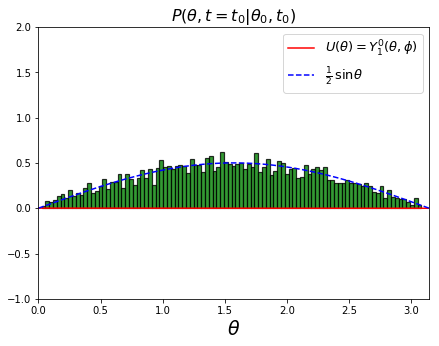

In [61]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
n,bins, rectangles = plt.hist(x1[0], bins = 100, normed = True, #
color = "g", alpha = 0.8, edgecolor='black', linewidth=1.2)
fig.canvas.draw()
plt.xlabel(r"$\theta$", fontsize = 19)
#plt.ylabel(r"$P(\theta,t = t_0| \theta_0, t_0)$", fontsize = 18)
#plt.legend(loc = 1, fontsize = 14)
plt.title(r"$P(\theta,t = t_0| \theta_0, t_0)$", fontsize = 16)
plt.plot(xpot,ypot, color = "r", linestyle = "-", label = r"$U(\theta) = Y_{1}^{0}(\theta, \phi)$")
plt.plot(xpot, 0.5*np.sin(xpot), color = "b", linestyle = "--",label = r"$\frac{1}{2}\,\sin{\theta}$")
plt.ylim(-1,2)
plt.xlim(0,np.pi)
plt.legend(loc=1, fontsize = 13)
plt.savefig("Y10_Hist_Theta_t0", dpi = 150)
plt.show()

In [34]:
Norm1 = 1159
D=1e-1
xt = np.linspace(0,np.pi,1000)
yt = (1./Norm1)*np.exp(-190*D*(np.sqrt(3./(4*np.pi)))*np.cos(xt))*np.sin(xt)

In [34]:
%pwd

u'/Users/adrianovaldesgomez/Documents/Adriano_Programming/Y10_28_10_2017'

In [62]:
D=1e-1

In [63]:
theta = np.linspace(0,np.pi,1000)
#U0 = 5.0*np.sqrt(2*D)

In [66]:
#pot_Y10_int = (theta)/2. - 1/4.*np.sin(2*theta)
pot_Y10_int = -np.cos(theta)
coeff_pot_Y10 = np.sqrt(3./(4*np.pi))*2*v0/D
#p0_Y10_int = (1/9.70341e13)*np.exp(coeff_pot_Y10*pot_Y10_int)*np.sin(theta)
p0_Y10_int = (1./(3.723731e7))*np.exp(coeff_pot_Y10*pot_Y10_int)*np.sin(theta)
xpot_Y10 = np.linspace(0,np.pi,1000)
ypot_Y10 = v0*np.sqrt(3./(4*np.pi))*np.cos(xpot)/dt

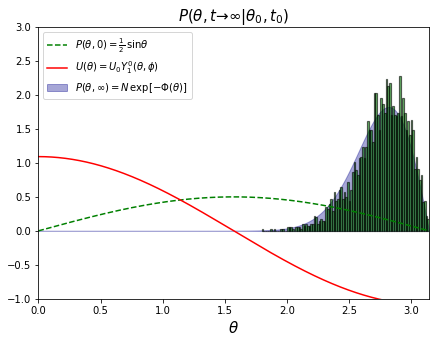

In [67]:
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)

n,bins, rectangles = plt.hist(x1[-1], bins = 100, normed = True, color = "g", #
alpha = .59, edgecolor='black', linewidth=1.2)
fig.canvas.draw()
plt.xlabel(r"$\theta$", fontsize = 15)

plt.title(r"$P(\theta,t \to \infty | \theta_0, t_0)$", fontsize = 15)
plt.plot(xpot, 0.5*np.sin(xpot), color = "g", linestyle = "--",label = r"$P(\theta,0) = \frac{1}{2}\,\sin{\theta}$")


plt.fill_between(xt, yt,y2 = 0, color = 'darkblue', alpha = .350, label=r'$P(\theta, \infty) = N \,\exp{[-\Phi(\theta)]}$')

plt.xlim(0,np.pi)
plt.ylim(-1,3)
plt.plot(xpot, ypot_Y10, color = "r", label = r"$U(\theta) =U_0 Y_{1}^{0}(\theta, \phi)$")
plt.legend(loc=2, fontsize = 10)

#plt.savefig("Y10_Hist_Theta_tinf", dpi = 250)

plt.show()

## Integramos la ecuación (estacionaria) transformada de Fokker-Planck con respecto a $\theta$

In [68]:
!pwd

/Users/adrianovaldesgomez/Documents/Adriano_Programming


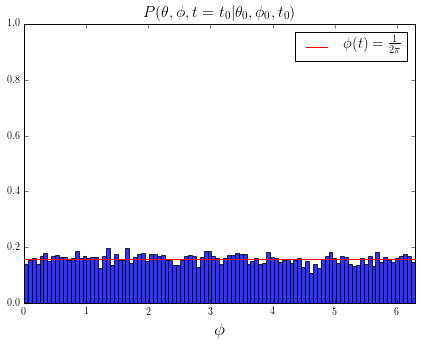

In [160]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
n,bins, rectangles = plt.hist(x2[0], bins = 100, normed = True, #
color = "b", alpha = 0.8)
fig.canvas.draw()
plt.plot(np.linspace(0,2*np.pi,100), (1./(2*np.pi))*np.ones(len(np.linspace(0,2*np.pi,100))), color = "r",#
label = r"$\phi(t) = \frac{1}{2\pi}$")
plt.xlabel(r"$\phi$", fontsize = 19)
plt.title(r"$P(\theta, \phi,t = t_0| \theta_0, \phi_0, t_0)$", fontsize = 16)
plt.ylim(0,1)
plt.xlim(0,2*np.pi)
plt.legend(loc = 1, fontsize = 15)
plt.savefig("Y10_Hist_Phi_t0", dpi = 150)
plt.show()

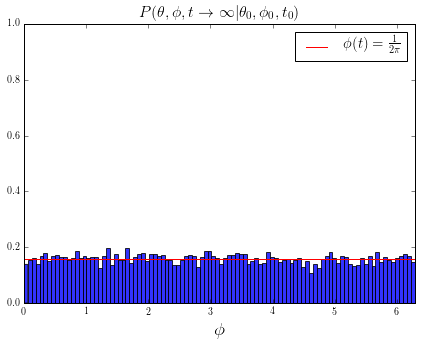

In [161]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
n,bins, rectangles = plt.hist(x2[0], bins = 100, normed = True, #
color = "b", alpha = 0.8)
fig.canvas.draw()
plt.plot(np.linspace(0,2*np.pi,100), (1./(2*np.pi))*np.ones(len(np.linspace(0,2*np.pi,100))), color = "r", #
label = r"$\phi(t) = \frac{1}{2\pi}$")
plt.xlabel(r"$\phi$", fontsize = 19)
plt.title(r"$P(\theta, \phi,t \to \infty | \theta_0, \phi_0, t_0)$", fontsize = 16)
plt.ylim(0,1)
plt.xlim(0,2*np.pi)
plt.legend(loc = 1, fontsize = 15)
plt.savefig("Y10_Hist_Phi_tinfty", dpi = 150)
plt.show()

In [34]:
tiempo = 0
dt = np.log(2)*1e-3
Nt = 5000
tiempos = [tiempo]
for i in range(Nt):
    tiempo = tiempo + dt
    tiempos.append(tiempo)
tiempos = np.array(tiempos)

In [36]:
from matplotlib import pyplot as plt

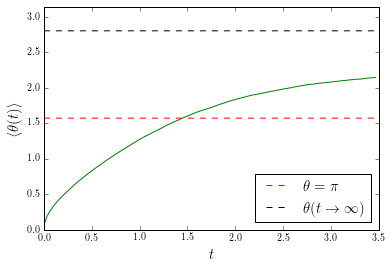

In [38]:
plt.rc('text', usetex=True)
plt.plot(tiempos, TMY101, color = 'g')
plt.plot(tiempos, np.pi/2*np.ones(len(tiempos)), color = "r", linestyle = "--", label = r"$\theta = \pi$")
plt.plot(tiempos, (2.8)*np.ones(len(tiempos)), color = "k", linestyle = "--", label = r"$\theta(t \to \infty)$")
#plt.plot(tiempos[:5800], np.arccos(np.exp(-14*D*np.array(tiempos[:5800]))))
#plt.plot(tiempos[:5800], np.pi/2*np.ones(len(tiempos[:5800])), color = 'r')
plt.xlabel(r'$t$', fontsize = 15)
plt.ylim(0,np.pi)
plt.ylabel(r'$\langle \theta(t) \rangle$', fontsize = 15)
plt.legend(loc = 4, fontsize = 15)
plt.savefig("Y10_Mean_Theta_t", dpi = 150)

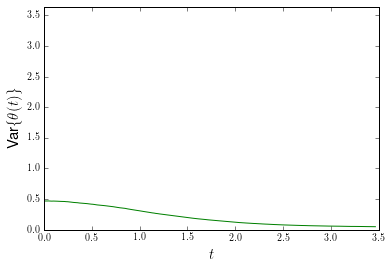

In [166]:
plt.rc('text', usetex=True)
plt.plot(tiempos, x5, color = 'g')
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$\mbox{Var}\{\theta(t)\}$', fontsize = 15)
plt.ylim(0,np.pi + 0.5)
plt.savefig("Y10_Var_Theta_t", dpi = 150)

In [171]:
np.var(x1[0])

0.46874064549509648

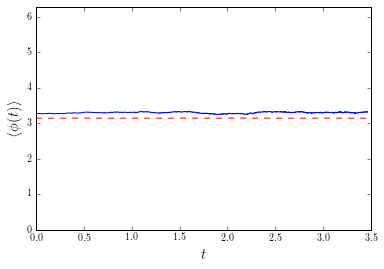

In [164]:
plt.rc('text', usetex=True)
plt.plot(tiempos, x6, color =  'b')
plt.plot(tiempos, np.pi*np.ones(len(tiempos)), color = "r", linestyle = "--")
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$$\langle \phi(t) \rangle$$', fontsize = 15)
plt.ylim(0,2*np.pi)
plt.savefig("Y10_Mean_Phi_t", dpi = 150)

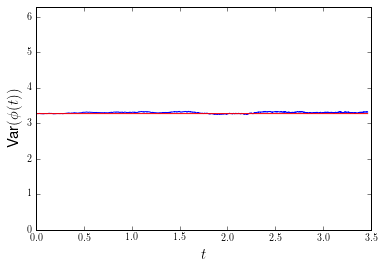

In [179]:
plt.rc('text', usetex=True)
plt.plot(tiempos, x6 , color = 'b')
plt.plot(tiempos, np.sqrt((13/12.)*(np.pi**2))*np.ones(len(tiempos)), color = "r", label = r"$$")
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$$\mbox{Var}(\phi(t))$$', fontsize = 15)
plt.ylim(0,2*np.pi)
plt.savefig("Y10_Var_Phi_t", dpi = 150)

In [174]:
np.sqrt(np.var(x2[-1]))

1.8197993863142048

In [177]:
np.sqrt((13/12.)*(np.pi**2))

3.2698733055752283

In [12]:
type(x1)

numpy.ndarray

In [16]:
len(x1[0])

10000

In [180]:
np.var?

In [181]:
Period_Chain = 2**(19937)-1

In [182]:
Period_Chain

4315424797388162648055235516337919839053935043226711505165250541403330680137658091130451362931858466554526993825764883531790221733458441390952826915460916801900787534374139629680192011448648090266141431844327698030006672810498409545158817607713296984376213462179039639134128520562761960051310664637664861599423667548653748024196435029593516866236390904794834769231397830137782078571241905447433284452918317297324231088826508132162646945107770781228282944477502268048805782002876465939916476626520090056149580034405435369038986289406179287201112083361480844748291354732836727787956564830784690911694586623016970240126024018702874665003344577457031543129299602518778079011937590286317108414964247337898626750330896137490576634090528957229001603800057163087519137397955504746815433325347499104624813250451634179655147057548145920085947261483621387555711686444578975088627799648730430845048422342062926651855602433933919084436892101842484467704272766460185291492527728092269753842677025733392895440120546

In [185]:
Period_Chain > 1e18

True